<a href="https://colab.research.google.com/github/elvispletsch/bibliotecapandas/blob/main/Modelo_de_an%C3%A1lise_de_m%C3%A9tricas_RFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

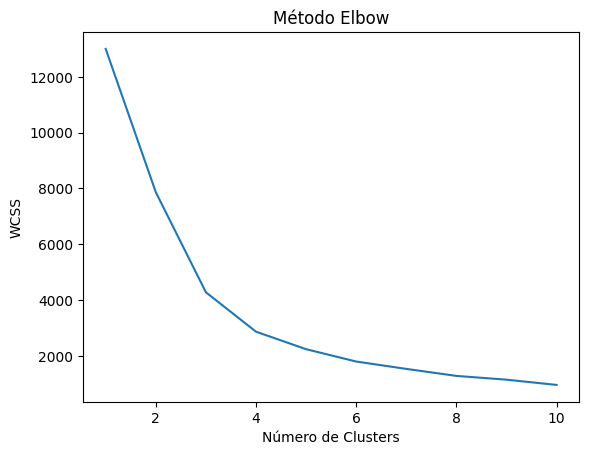

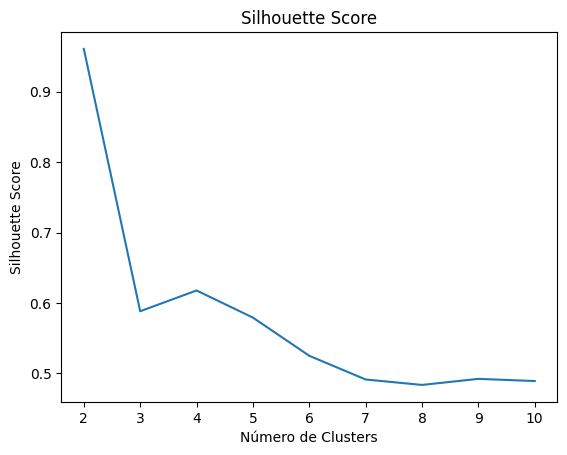

            Recency    Frequency      Monetary  Customer Count
Cluster                                                       
0        245.551978    27.174793     95.315659            1087
1          1.000000  5741.250000  22754.112500               4
2         40.112481   105.330971    320.189286            3245


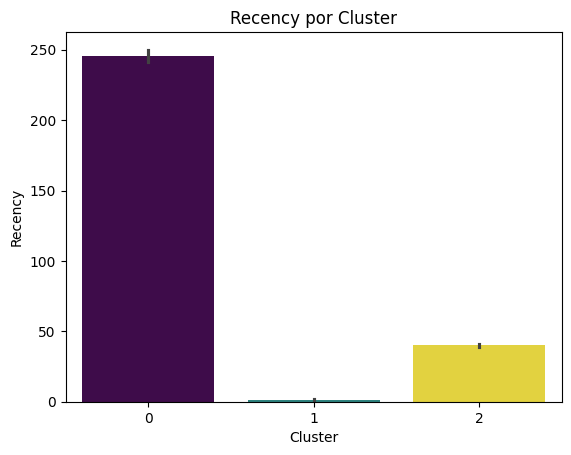

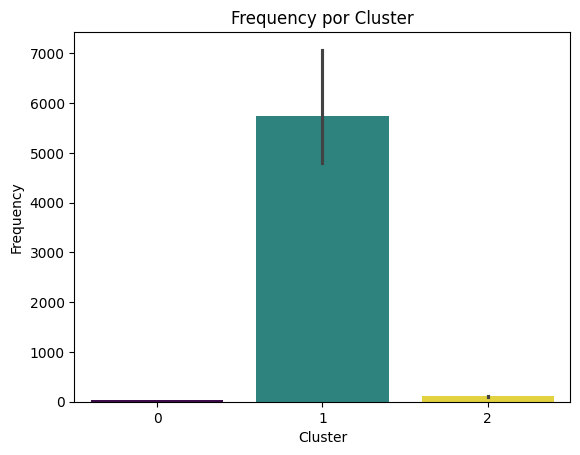

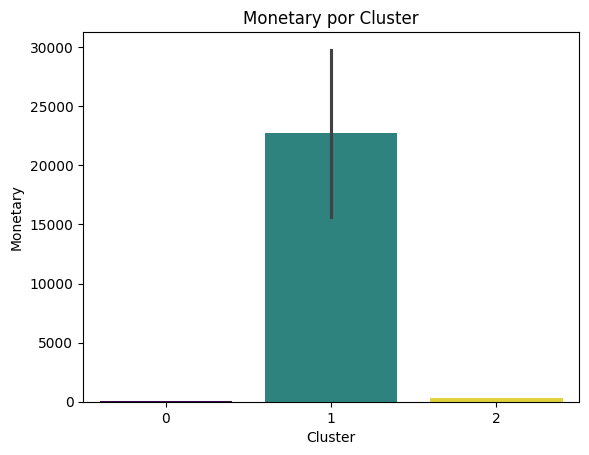

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Carregar dados
data = pd.read_csv('DADOS.csv', encoding='latin1')

# Limpeza de dados
data_clean = data.copy()
data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['UnitPrice'] > 0)]

# Converter InvoiceDate para datetime
data_clean.loc[:, 'InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

# Calcular Recency, Frequency e Monetary (RFM)
latest_date = data_clean['InvoiceDate'].max()
rfm = data_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Normalizar os dados RFM
rfm_normalized = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_normalized = (rfm_normalized - rfm_normalized.mean()) / rfm_normalized.std()

# Método Elbow
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

# Método Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    silhouette_scores.append(silhouette_score(rfm_normalized, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Escolher número de clusters (por exemplo, 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Analisar os clusters
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer Count'})

print(cluster_analysis)

# Visualizar clusters
sns.barplot(x='Cluster', y='Recency', data=rfm, palette='viridis', hue='Cluster', legend=False)
plt.title('Recency por Cluster')
plt.show()

sns.barplot(x='Cluster', y='Frequency', data=rfm, palette='viridis', hue='Cluster', legend=False)
plt.title('Frequency por Cluster')
plt.show()

sns.barplot(x='Cluster', y='Monetary', data=rfm, palette='viridis', hue='Cluster', legend=False)
plt.title('Monetary por Cluster')
plt.show()
